# An Example REST API with Machine Using Flask and Scikit-learn

by Marcio Gualtieri

## Installing Dependencies

Run this block of code to install all these dependencies if you don't have them:

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas==1.1.2
!{sys.executable} -m pip install scikit-learn==0.23.2
!{sys.executable} -m pip install matplotlib==3.3.1
!{sys.executable} -m pip install Flask==1.1.2

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pip in /home/franco/.local/lib/python3.8/site-packages (20.2.3)
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Importing Dependencies

All the imports go here:

In [2]:
import pandas as pd
import numpy as np
import string
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from flask import Flask, jsonify, request

## Generating Synthetic Data

We will be defining a global seed for the whole notebook for reproducibility:

In [3]:
SEED = 123

np.random.seed(SEED)

For computing a dataframe with synthetic random data, we are going to define the following functions:

In [4]:
def generate_numbers(N):
    return np.random.randn(1, N)[0]

assert generate_numbers(3).shape == (3,)
assert generate_numbers(3).dtype == np.dtype('float64')

def generate_letters(N):
    return np.random.choice(list(string.ascii_uppercase), N)

assert generate_letters(3).shape == (3,)
assert generate_letters(3).dtype == np.dtype('<U1')

Given that this is just an example, we are going to use a fairly small data-set:

In [5]:
N = 1000

data_df = pd.DataFrame(columns=['NUMBER1', 'NUMBER2', 'NUMBER3', 'LETTER1'])
data_df.NUMBER1 = generate_numbers(N)
data_df.NUMBER2 = generate_numbers(N)
data_df.NUMBER3 = generate_numbers(N)
data_df.LETTER1 = generate_letters(N)

data_df.sample(12)

,NUMBER1,NUMBER2,NUMBER3,LETTER1
863,-0.662023,0.053536,-1.129567,A
432,0.182635,0.065770,0.166094,G
643,-0.345676,-0.046507,-1.450647,P
944,0.195246,0.311453,-0.103934,I
325,0.540774,-0.204227,0.682255,G
782,-1.590748,0.335376,-0.298454,G
462,-0.309896,-0.256017,1.611584,Z
920,0.118998,-1.012662,0.120498,C
570,1.637441,0.062215,-0.368085,R
115,-0.524849,1.295082,-0.206787,J


In [6]:
data_df.shape

(1000, 4)

## Extracting Features

The specification for this challenge refered to "numbers", which usually means float numbers, not integers, thus, we are dealing with continous variables, which implies regression for any of the numeric columns.

We are going to apply one-hot encoding for the only categorical feature, that is, "LETTER1":

In [7]:
features_df = pd.get_dummies(data_df)
features_df.sample(12)

,NUMBER1,NUMBER2,NUMBER3,LETTER1_A,LETTER1_B,LETTER1_C,LETTER1_D,LETTER1_E,LETTER1_F,LETTER1_G,...,LETTER1_Q,LETTER1_R,LETTER1_S,LETTER1_T,LETTER1_U,LETTER1_V,LETTER1_W,LETTER1_X,LETTER1_Y,LETTER1_Z
127,0.971047,-0.736352,-1.034197,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
375,-0.974754,0.363989,0.768231,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
545,-1.485573,-0.357539,-0.714663,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
636,0.069857,0.995418,1.246920,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
905,1.003126,1.828910,-1.404956,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
224,-0.097375,1.387062,1.254441,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
781,-0.280841,-0.993701,2.775053,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208,0.184864,-0.383106,0.159136,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
458,-0.271584,0.487785,-0.655541,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
799,-0.992187,-1.355146,-0.943882,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


For the purposes of this experiment, we are going to use "NUMBER1" for the labels, thus, this immediately implies regression for our machine learning model:

In [8]:
label_name = 'NUMBER1'
labels = np.array(features_df[label_name])

features = features_df.drop(label_name, axis = 1)
feature_names = list(features.columns)
features = np.array(features)

In [9]:
features.shape

(1000, 28)

Due to the one-hot encoding, we have 28 features (2 numeric and 26 categorical):

In [10]:
feature_names

['NUMBER2',
 'NUMBER3',
 'LETTER1_A',
 'LETTER1_B',
 'LETTER1_C',
 'LETTER1_D',
 'LETTER1_E',
 'LETTER1_F',
 'LETTER1_G',
 'LETTER1_H',
 'LETTER1_I',
 'LETTER1_J',
 'LETTER1_K',
 'LETTER1_L',
 'LETTER1_M',
 'LETTER1_N',
 'LETTER1_O',
 'LETTER1_P',
 'LETTER1_Q',
 'LETTER1_R',
 'LETTER1_S',
 'LETTER1_T',
 'LETTER1_U',
 'LETTER1_V',
 'LETTER1_W',
 'LETTER1_X',
 'LETTER1_Y',
 'LETTER1_Z']

Note again that this leaves us one label:

In [11]:
label_name

'NUMBER1'

The first step when trying to do feature engineering is to find the correlation between the labeland the features:

In [12]:
features_df[features_df.columns].corr()[label_name][1:]

NUMBER2      0.000973
NUMBER3      0.038228
LETTER1_A   -0.017539
LETTER1_B   -0.034018
LETTER1_C   -0.032077
LETTER1_D    0.029479
LETTER1_E   -0.019225
LETTER1_F    0.028593
LETTER1_G   -0.034286
LETTER1_H    0.010499
LETTER1_I   -0.003001
LETTER1_J    0.025424
LETTER1_K    0.028979
LETTER1_L    0.008999
LETTER1_M   -0.001687
LETTER1_N   -0.017678
LETTER1_O    0.010548
LETTER1_P   -0.074807
LETTER1_Q   -0.016054
LETTER1_R    0.023006
LETTER1_S    0.031968
LETTER1_T   -0.041883
LETTER1_U    0.088623
LETTER1_V    0.020600
LETTER1_W    0.005305
LETTER1_X    0.000464
LETTER1_Y   -0.052176
LETTER1_Z    0.043355
Name: NUMBER1, dtype: float64

You may have noticed that there isn't a significant correlation between the label and any of the features,
which we can make it even more clear by using a visualization:

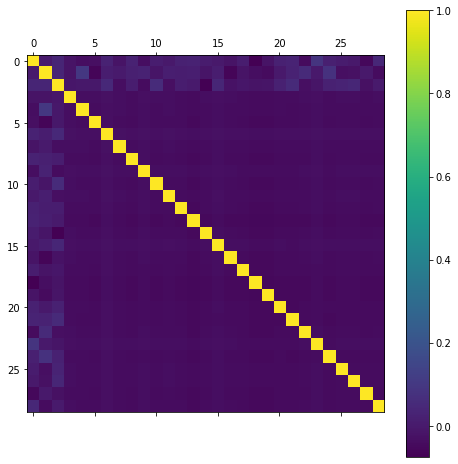

In [13]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.matshow(features_df.corr())
plt.colorbar()
plt.show()

In principle, only by looking at this diagram, we realize that there isn't much sense into using machine learning here, but given that the purpose of this notebook is to serve as an example of creating a regression model using [`sklearn`](https://scikit-learn.org/), let's keep going.

## Creating a Base Model

The purpose of this section is to create a base model with the default parameters that we can compare later with the best model that we can find.

Our first step is to split our data-set into a training datas-set and a testing data-set:

In [14]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features,
    labels,
    test_size = 0.25,
    random_state = SEED
)

We well be using 75% of our data-set for training and the remaining for evaluating our model.

Let's create our base model:

In [15]:
base_random_forest_regressor = RandomForestRegressor(random_state = SEED)

Here's the hyperparamters for our base model:

In [16]:
base_random_forest_regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

Given that our label is a continuous variable, we will make use of a evaluation method proper for regression models, which could be root mean square error (RMSE), mean absolute error (MAE), R squared, or Adjusted R squared. We will be using the most popular one, RMSE, which happens to be part of the `sklearn` library:

In [17]:
base_random_forest_regressor.fit(train_features, train_labels);
test_predictions = base_random_forest_regressor.predict(test_features)

base_mean_squared_error = mean_squared_error(test_predictions, test_labels)
base_mean_squared_error

1.2882227094852712

## Random Grid Search for the Best Model

We need to find the hyperparameters that will give us the best fit. Here are the ranges we will be examining them:

In [18]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

These ranges were obtained by trial and error. Given the values we get for best hyperparameters, it's safe to assume that they are within these ranges .

Now we can build a configuration from these ranges:

In [19]:
random_grid_search_config = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

random_grid_search_config

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

Finally we perform the grid search. This block of code will take the order of minutes to run, depending on your computer:

In [20]:
random_grid_search = RandomizedSearchCV(
    estimator = base_random_forest_regressor,
    param_distributions = random_grid_search_config,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=SEED,
    n_jobs = -1)

random_grid_search.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=123, verbose=2)

That's the best hyperparameters found by the search:

In [21]:
random_grid_search.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

## Creating the Best Model

Now we can fit the model using our training data as we did for the base model:

In [22]:
best_random_forest_regressor = RandomForestRegressor(**random_grid_search.best_params_, random_state = SEED)
best_random_forest_regressor.fit(train_features, train_labels);

Once again we are going to evaluate our best model using RMSE:

In [23]:
test_predictions = best_random_forest_regressor.predict(test_features)

best_mean_squared_error = mean_squared_error(test_predictions, test_labels)
best_mean_squared_error

1.1921136391585132

Note that we have achieved quite a bit of reduction on the RMSE using random grid search.

Usually, we would worry about the possibility of overfitting here, but given the nature of our data (synthetic, randomly generated, and with little correlation among them), we are going to stop analysis here. But we have proved the point that random grid search works.

Now that we have our "production model". We are going to serialize it and save it to a file so we don't need to repeat the process of creating it all over again:

In [24]:
model_file = 'model.pickle'
pickle.dump(best_random_forest_regressor, open(model_file, 'wb'))

We are going to use this model to build a predictive REST API in the next section.

## Building a Predictive REST API

The plan is to send a POST request to our API with the following load:

```json
{
  "NUMBER2": 2.,
  "NUMBER3": 3.,
  "LETTER1": "A"
}
```

Which will return a prediction for "NUMBER1" as follows:

```json
{
  "NUMBER1":[-0.040527403534144496]
}
```

The first thing we need to do is to extract features from the input JSON data:

In [25]:
def one_hot_encode_feature(data, feature):
     data[feature + '_' + data[feature]] = 1
     del data[feature]
     return data

assert one_hot_encode_feature({'test_feature': 'A'}, 'test_feature') == {'test_feature_A': 1}
    
def extract_features(data):
    one_hot_encode_feature(data, 'LETTER1')
    data_df = pd.DataFrame(columns=feature_names)
    data_df = data_df.append(data, ignore_index=True) 
    data_df = data_df.fillna(0)
    return np.array(pd.get_dummies(data_df))

np.testing.assert_array_equal(
    extract_features(
        {'NUMBER2': 2., 'NUMBER3': 3., 'LETTER1': 'A'}),
        np.array([[2., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0.]]
    )
)

Now we can build a simple REST API using [`Flask`](https://flask.palletsprojects.com/en/1.1.x/):

In [26]:
app = Flask(__name__)

model = pickle.load(open(model_file, 'rb' ) )

@app.route('/predict', methods=['POST'])
def predict():
     prediction = model.predict(extract_features(request.json))
     return jsonify({label_name: list(prediction)})

app.run(port=8080)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8080/ (Press CTRL+C to quit)
127.0.0.1 - - [13/Sep/2020 17:37:25] "POST /predict HTTP/1.1" 200 -


The code above will run a Flask server in your localhost using port 8080. You need to stop the notebook's kernel to stop the server. While the server is running we my open a UNIX terminal and send a request using curl as follows:

```bash
curl --header "Content-Type: application/json" \
  --request POST \
  --data '{"NUMBER2": 2.0,"NUMBER3":3.0, "LETTER1": "A"}' \
  http://localhost:8080/predict
```

You should get a response similar to the following:

```bash
$ curl --header "Content-Type: application/json"   --request POST   --data '{"NUMBER2": 2.0,"NUMBER3":3.0, "LETTER1": "A"}'   http://localhost:8080/predict
{"NUMBER1":[-0.040527403534144496]}
```

Normally (that is, in a production setting) I would separate the the REST API in its own project (with its own `requirements.txt`, unit tests, etc), but given that the purpose of this notebook is exploration, this should suffice.